In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
import os
import geological_segmentation as geoseg

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
from pymatsolver import Pardiso as Solver  # this is a fast linear solver 

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14


In [4]:
# load mesh
mesh = discretize.TensorMesh.read_UBC("/home/juanito/Documents/projects/mcD/dflt/dcinv2d.msh")
actind = np.ones(mesh.n_cells, dtype=bool)

mcd_model =  np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/mcd_iterations/model_12.npy"))

segmentor = geoseg.SamClassificationModel(
    mesh,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)
segmentor.segment_model.cuda()
masks_iter_2 = segmentor.fit(np.log(mcd_model))

mask 0 vote total: 1
mask 1 vote total: 0
mask 2 vote total: 0
mask 3 vote total: 0
mask 4 vote total: 0
[]
[[1.00000000e+00 4.33301798e-01 4.53309157e-03 2.83822138e-03
  2.83822138e-03]
 [4.33301798e-06 1.00000000e+00 0.00000000e+00 6.55021834e-03
  6.55021834e-03]
 [4.53309157e-08 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.83822138e-13 6.55021834e-13 0.00000000e+00 1.00000000e-05
  1.00000000e+00]
 [2.83822138e-13 6.55021834e-13 0.00000000e+00 1.00000000e-05
  1.00000000e+00]]


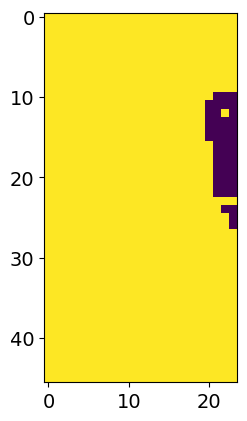

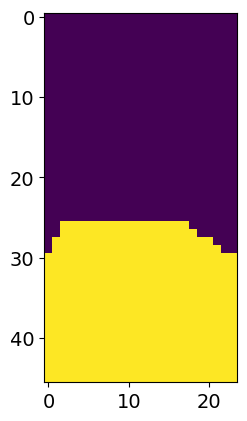

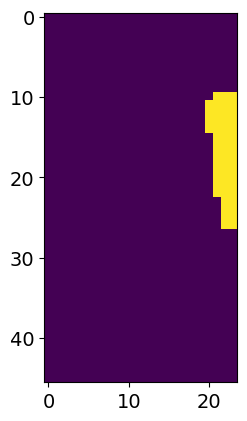

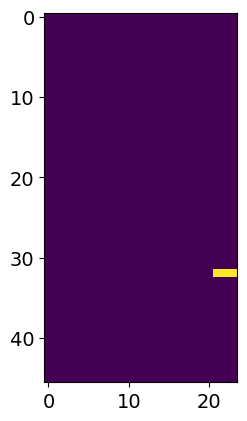

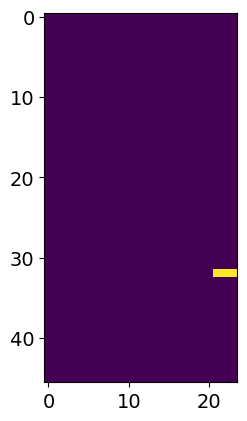

In [5]:
for mask in masks_iter_2:
    plt.imshow(mask['segmentation'])
    plt.show()

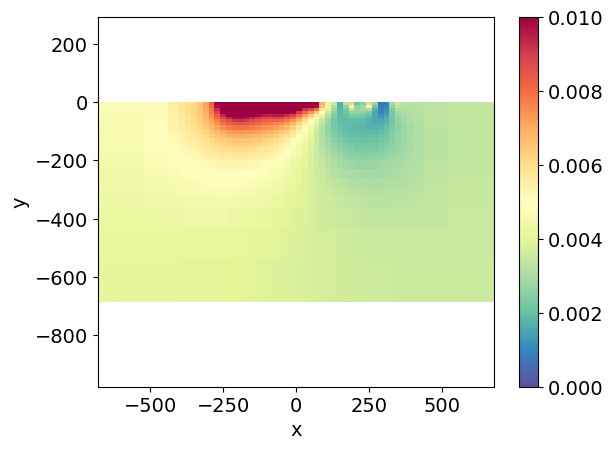

In [ ]:
dd = mesh.plot_image(mcd_model, pcolor_opts={"cmap": "Spectral_r"}, clim=[0, 0.01])
plt.axis('equal')
plt.colorbar(dd[0])

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
seg_data = masks_iter_2[1]['segmentation']  # results[2]['segmentation']
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 1)

# Apply PCA to determine orientation
if len(object_pixels) > 1:

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees} {pca.singular_values_}")
    angle_radians = angle_degrees * np.pi / 180

Orientation angle (degrees): -176.27200201714908 [35.3148718  8.8210345]


/tmp/ipykernel_4154/1652909241.py:12: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = mesh.plotImage(mcd_model, clim=clim, ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_4154/1652909241.py:99: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d3 = mesh.plotImage(flatten, clim=clim, ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})


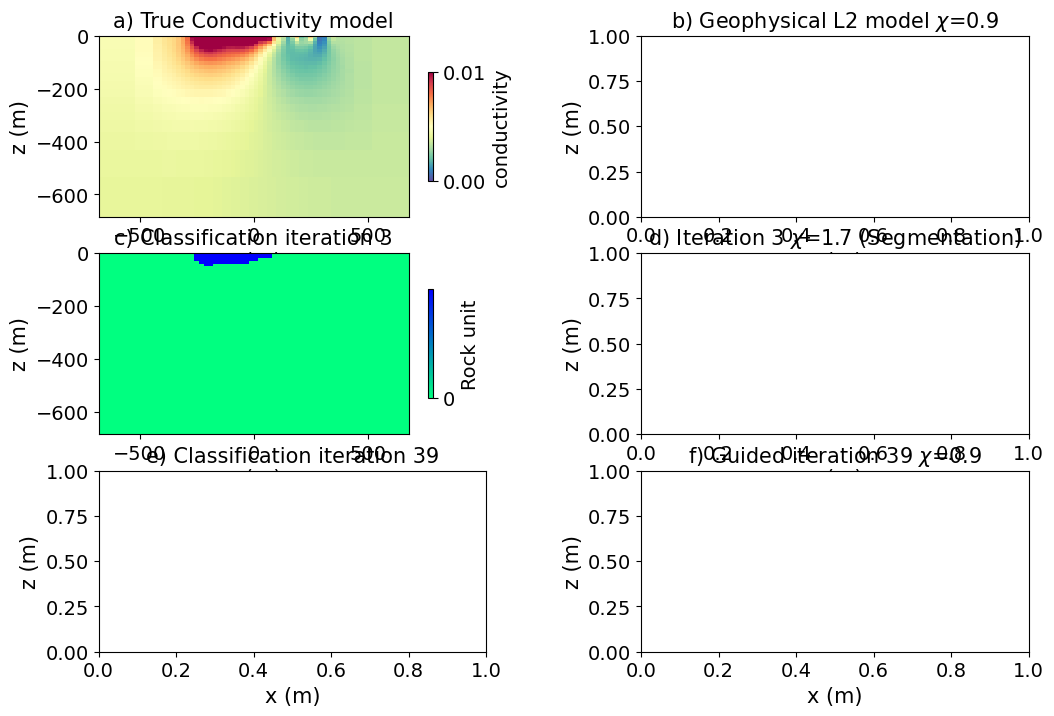

In [20]:
# from matplotlib.colors import LogNorm
# import matplotlib as mpl

sam_model = segmentor
fig, ax = plt.subplots(3, 2, figsize=(12, 8))


# subplot 0,0 ----------------------------------------------------------
flatten = mcd_model
conductivity_model_log10_true = np.log10(np.exp(flatten))
clim=[0, 0.01]  # clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
d1 = mesh.plotImage(mcd_model, clim=clim, ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d1[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], shrink=0.6).ax.tick_params(labelsize=14)
# clim = [np.log10(np.exp(dip_model3)).min(), np.log10(np.exp(dip_model3)).max()]
# d1 = utils.plot2Ddata(

#     meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
#     contourOpts={'cmap':"Spectral_r", 'alpha':1},
#     ax=ax[0, 0],
#     # level=True,
#     ncontour=5,
#     # shade=True,
#     # levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=clim,
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# norm = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_true.min(), vmax=conductivity_model_log10_true.max()
# )

# # plt.colorbar(d1[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)


# # subplot 0,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0, 1],
#     level=True,
#     ncontour=2,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")
# conductivity_model_log10 = np.log10(np.exp(dip_model3))
# clim = [conductivity_model_log10.min(), conductivity_model_log10.max()]
# d2 = meshCore.plotImage(conductivity_model_log10, clim=clim, ax=ax[0, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d2[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)
# # d2 = utils.plot2Ddata(

# #     meshCore.gridCC, conductivity_model_log10, nx=500,ny=500,
# #     contourOpts={'cmap':"Spectral_r", 'alpha':1},
# #     ax=ax[0, 1],
# #     level=True,
# #     ncontour=8,
# #     shade=True,
# #     levelOpts={'colors':'k','linewidths':0.25},
# #     method='linear',
# #     clim=clim,
# #     shade_ncontour=100,
# #     shade_azimuth=315.0,
# #     shade_angle_altitude=45.0,
    
# # )

# # norm = mpl.colors.Normalize(
# #     vmin=conductivity_model_log10.min(), vmax=conductivity_model_log10.max()
# # )

# # plt.colorbar(d2[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# # subplot 1,0 ----------------------------------------------------------

flatten = masks_iter_2[1]['segmentation'].flatten(order='F')  # np.load('iter40-segmentations.npy').astype(int).flatten(order='F')
d3 = mesh.plotImage(flatten, clim=clim, ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})
# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     ax=ax[1, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# d3 = utils.plot2Ddata(

#     meshCore.gridCC, flatten.flatten(order='F'),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':1},
#     ax=ax[1, 0],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )

# # norm_seg = mpl.colors.Normalize(
# #     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# # )

plt.colorbar(d3[0], cmap='winter_r', label='Rock unit', ticks=[1,0], shrink=0.6).ax.tick_params(labelsize=14)

# # subplot 1,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[1, 1],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# dip_model1_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_2.npy")
# conductivity_model_log10_1_1 = np.log10(np.exp(dip_model1_1))
# d5 = meshCore.plotImage(conductivity_model_log10_1_1, clim=clim, ax=ax[1, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d5[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)
# # d5 = utils.plot2Ddata(

# #     meshCore.gridCC, conductivity_model_log10_1_1,nx=500,ny=500,
# #     contourOpts={'cmap':"Spectral_r", 'alpha':1},
# #     ax=ax[1, 1],
# #     level=True,
# #     ncontour=8,
# #     shade=True,
# #     levelOpts={'colors':'k','linewidths':0.25},
# #     method='linear',
# #     clim=clim,
# #     shade_ncontour=100,
# #     shade_azimuth=315.0,
# #     shade_angle_altitude=45.0,
    
# # )

# # # norm = mpl.colors.Normalize(
# # #     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# # # )

# # plt.colorbar(d5[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# # subplot 2,0 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# flatten = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mask_3_dip_iter39.npy").astype(int) # masks_iter39[-1]['segmentation'].flatten(order='F')
# d6 = utils.plot2Ddata(

#     meshCore.gridCC, flatten.flatten(order='F'),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':1},
#     #clim=[0,5],
#     ax=ax[2, 0],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )
# plt.colorbar(d6[0], cmap='winter_r', label='Rock unit', ticks=[0,1], shrink=0.6).ax.tick_params(labelsize=14)

# # subplot 2,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2, 1],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# # flatten = masks3[3]['segmentation'].flatten(order='F')
# dip_model2_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_39.npy")
# conductivity_model_log10_2_1 = np.log10(np.exp(dip_model2_1))
# d7 = meshCore.plotImage(conductivity_model_log10_2_1, clim=clim, ax=ax[2, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d7[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)

ax[0, 1].set_title(r'b) Geophysical L2 model $\chi$=0.9',fontsize=15)
ax[0, 1].set_xlabel('x (m)',fontsize=15)
ax[0, 1].set_ylabel('z (m)',fontsize=15)


ax[0, 0].set_title('a) True Conductivity model',fontsize=15)
ax[0, 0].set_xlabel('x (m)',fontsize=15)
ax[0, 0].set_ylabel('z (m)',fontsize=15)

ax[1, 0].set_title('c) Classification iteration 3',fontsize=15)
ax[1, 0].set_xlabel('x (m)',fontsize=15)
ax[1, 0].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[1, 1].set_title(r'd) Iteration 3 $\chi$=1.7 (Segmentation)',fontsize=15)
ax[1, 1].set_xlabel('x (m)',fontsize=15)
ax[1, 1].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('e) Classification iteration 39',fontsize=15)
ax[2, 0].set_xlabel('x (m)',fontsize=15)
ax[2, 0].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 1].set_title(r'f) Guided iteration 39 $\chi$=0.9',fontsize=15)
ax[2, 1].set_xlabel('x (m)',fontsize=15)
ax[2, 1].set_ylabel('z (m)',fontsize=15)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.4)